In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.linear_model import LogisticRegression

ImportError: cannot import name 'MultilayerPerceptronClassifier'

In [2]:
digits = load_digits()
X_dev, X_eval, y_dev, y_eval = train_test_split(digits.data, digits.target, test_size=0.2)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def make_scaling_lr(**params):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**params))          
    ])


def make_scaling_mlp(**params):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MultilayerPerceptronClassifier(**params))          
    ])

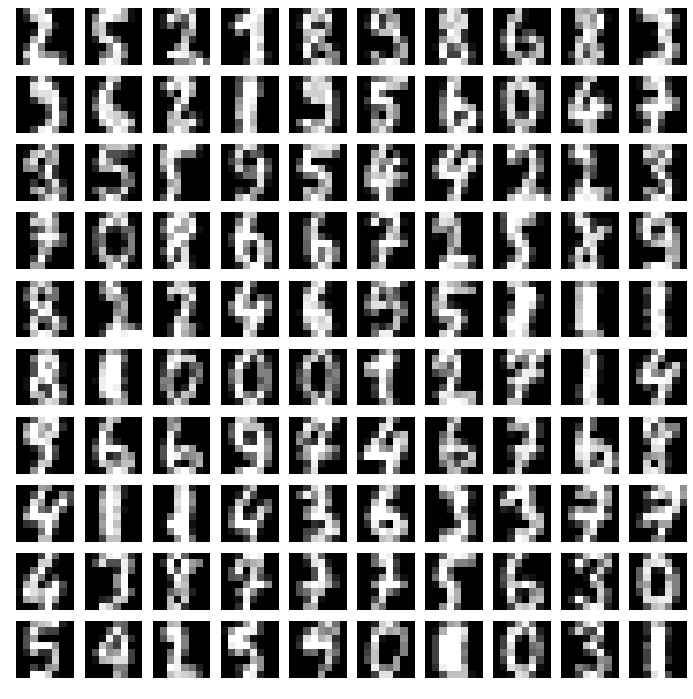

In [49]:
def plot_images(images, n_rows=10, n_cols=10, ordering=None):
    if ordering is None:
        indices = np.arange(len(images))
    else:
        indices = ordering.argsort()[::-1]
    plt.figure(figsize=(1.2 * n_cols, 1.2 * n_rows))
    plt.gray()
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < len(images):
                idx = indices[idx]
                plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
                plt.imshow(images[idx].reshape(8, 8), interpolation='nearest')
                plt.axis('off')
                if ordering is not None:
                    plt.title("{:.2f}".format(ordering[idx]))
                
plot_images(X_dev)

In [5]:
lr = make_scaling_lr(C=0.1).fit(X_dev, y_dev)
lr.score(X_eval, y_eval)

0.96388888888888891

In [6]:
nn = make_scaling_mlp(n_hidden=100, alpha=1).fit(X_dev, y_dev)
nn.score(X_eval, y_eval)

0.97222222222222221

In [7]:
scores = cross_val_score(nn, X_dev, y_dev, cv=5, n_jobs=-1)
print(np.mean(scores), np.std(scores))

(0.97773664343786293, 0.0035130399247694333)


In [20]:
net = nn.named_steps['classifier']

(100, 10)

Display the shuffle filters of the intput to hidden layer, ordered by the weight attributed by the output layer connection. Here we order the filters by their connection with the output unit for the 0 digit:

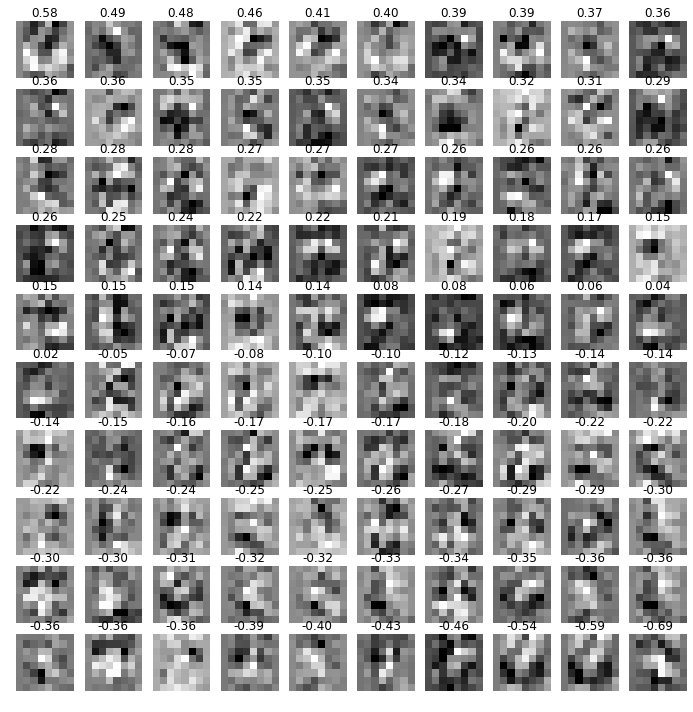

In [28]:
plot_images(net.coef_hidden_.T, ordering=net.coef_output_[:, 0])

In [10]:
def shuffle_columns(X, copy=True, seed=None):
    rng = np.random.RandomState(seed)
    if copy:
        X = X.copy()
    for i in range(X.shape[1]):
        rng.shuffle(X[:, i])
    return X


def make_membership_pbm(X, seed=None):
    rng = np.random.RandomState(seed)
    n_samples, n_features = X.shape
    shuffle_idx = rng.permutation(2 * n_samples)
    
    X = np.vstack([X, shuffle_columns(X, seed=seed)])
    y = np.concatenate([np.ones(n_samples), -np.ones(n_samples)])
    return X[shuffle_idx], y[shuffle_idx]

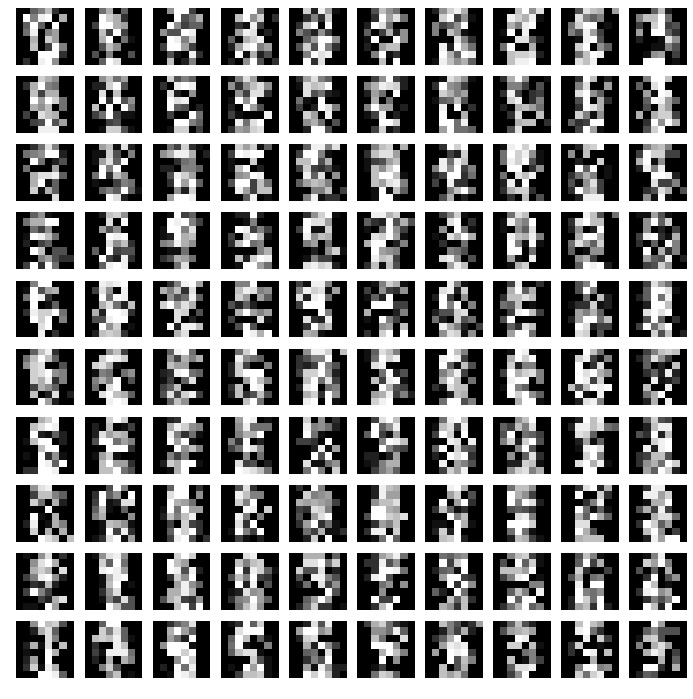

In [11]:
plot_images(shuffle_columns(X_dev))

In [12]:
X_mem_dev, y_mem_dev = make_membership_pbm(X_dev)

X_mem_dev.shape

(2874, 64)

In [13]:
scores = cross_val_score(make_scaling_lr(C=1), X_mem_dev, y_mem_dev, cv=5)
scores.mean(), scores.std()

(0.40814603847901837, 0.016766430451962418)

In [60]:
%%time
nn_1 = make_scaling_mlp(n_hidden=100, alpha=1)
scores = cross_val_score(nn_1, X_mem_dev, y_mem_dev, cv=5, n_jobs=-1)
print(np.mean(scores), np.std(scores))

(0.97773428268444174, 0.0057505213697114314)
CPU times: user 29.3 ms, sys: 35.6 ms, total: 64.9 ms
Wall time: 10.3 s


In [61]:
%time _ = nn_1.fit(X_mem_dev, y_mem_dev)

CPU times: user 8.72 s, sys: 3.78 s, total: 12.5 s
Wall time: 4.47 s


In [62]:
from sklearn.utils.extmath import safe_sparse_dot

def hidden_activate(nn, X):
    a = safe_sparse_dot(X, nn.coef_hidden_) + nn.intercept_hidden_
    return nn.activation_func(a)

net_1 = nn_1.named_steps['classifier']
X_dev_1 = hidden_activate(net_1, X_dev)

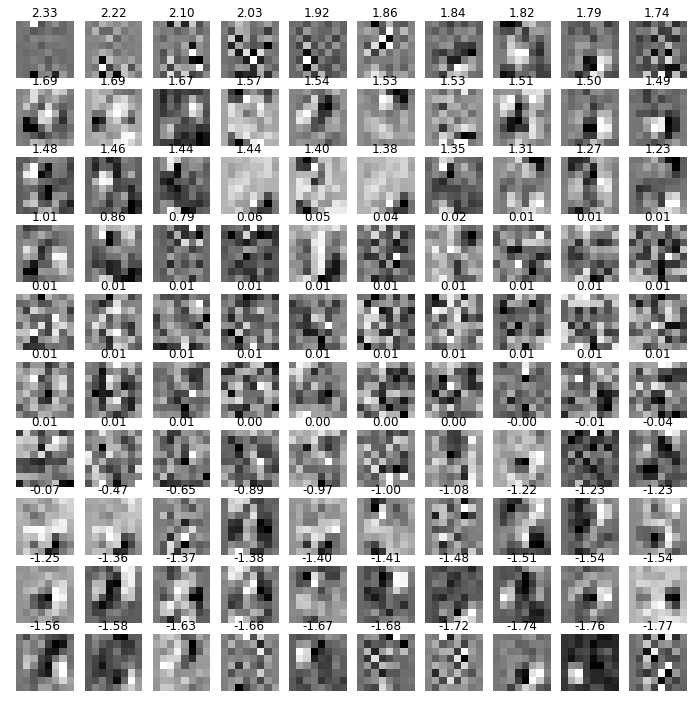

In [64]:
plot_images(net_1.coef_hidden_.T, ordering=net_1.coef_output_[:, 0])

In [37]:
X_mem_dev_2, y_mem_dev_2 = make_membership_pbm(X_dev_1)

In [19]:
%%time
nn_2 = make_scaling_mlp(n_hidden=100, alpha=1)
scores = cross_val_score(nn_2, X_mem_dev_2, y_mem_dev_2, cv=5, n_jobs=-1)
print(np.mean(scores), np.std(scores))

(0.99478200272685968, 0.002458645027670302)
CPU times: user 16 ms, sys: 84 ms, total: 100 ms
Wall time: 7.39 s


In [20]:
%%time
net_2 = nn_2.fit(X_mem_dev_2, y_mem_dev_2).named_steps['classifier']
X_dev_2 = hidden_activate(net_2, X_dev_1)

CPU times: user 10.7 s, sys: 80 ms, total: 10.8 s
Wall time: 7.82 s


Evaluate the benefit of adding the new features:

In [21]:
cross_val_score(make_scaling_lr(C=1),
                X_dev, y_dev,
                cv=5, n_jobs=-1).mean()

0.95823412698412702

In [22]:
cross_val_score(make_scaling_lr(C=1),
                np.hstack([X_dev, X_dev_1]), y_dev,
                cv=5, n_jobs=-1).mean()

0.95825106465350385

In [23]:
cross_val_score(LogisticRegression(C=1),
                np.hstack([X_dev, X_dev_1, X_dev_2]), y_dev,
                cv=5, n_jobs=-1).mean()

0.96172570654277967

In [24]:
cross_val_score(make_scaling_mlp(n_hidden=100, alpha=1.),
                np.hstack([X_dev, X_dev_1, X_dev_2]), y_dev,
                cv=5, n_jobs=-1).mean()

0.96868708865660069

A significant fraction of the signal is preserve by the successive embeddings:

In [25]:
cross_val_score(make_scaling_lr(C=1), X_dev_1, y_dev, cv=5, n_jobs=-1).mean()

0.95685733643050719

In [26]:
cross_val_score(make_scaling_lr(C=1), X_dev_2, y_dev, cv=5, n_jobs=-1).mean()

0.89840060007742939

In [27]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_dev_1, X_dev_2]), y_dev, cv=5, n_jobs=-1).mean()

0.95615805265195508

Compare with random non-linear embedding features:

In [28]:
rnd = np.random.normal(scale=1., size=(X_dev.shape[1], 200))

In [29]:
from sklearn.utils.extmath import logistic_sigmoid

X_dev_proj = logistic_sigmoid(np.dot(scale(X_dev), rnd))

In [30]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_dev, X_dev_proj]), y_dev, cv=5, n_jobs=-1).mean()

0.95476432442895853

Try to use extended features for supervised learning

In [31]:
len(X_dev)

1437

In [32]:
cross_val_score(make_scaling_lr(C=1), X_dev[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.91999999999999993

In [33]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_dev, X_dev_proj])[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.88500000000000001

In [34]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_dev, X_dev_1, X_dev_2])[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.94000000000000006

In [35]:
cross_val_score(make_scaling_mlp(alpha=1), X_dev[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.94999999999999996

In [36]:
cross_val_score(make_scaling_mlp(alpha=1), np.hstack([X_dev, X_dev_1, X_dev_2])[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.96499999999999986

Simulating high dim problems with noisy variables

In [37]:
n_samples_dev, n_features = X_dev.shape
n_features_highdim = 1000
highdim_proj = np.random.normal(scale=1., size=(n_features, n_features_highdim))
noise = np.random.normal(scale=1, size=(n_samples_dev, n_features_highdim))
X_highdim_dev = logistic_sigmoid(np.dot(X_dev, highdim_proj)) + noise

In [38]:
cross_val_score(make_scaling_lr(C=1), X_highdim_dev, y_dev, cv=5, n_jobs=-1).mean()

0.73554732868757267

In [39]:
from sklearn.decomposition import RandomizedPCA
X_highdim_pca_dev = RandomizedPCA(n_components=30).fit_transform(X_highdim_dev)

In [40]:
cross_val_score(make_scaling_lr(C=1), X_highdim_pca_dev, y_dev, cv=5, n_jobs=-1).mean()

0.84269986449864498

In [41]:
def nn_transform(X, n_hidden=100):
    X_mem_1, y_mem_1 = make_membership_pbm(X)
    model_1 = make_scaling_mlp(n_hidden=n_hidden, alpha=1)
    model_1.fit(X_mem_1, y_mem_1)
    X_1 = hidden_activate(model_1.named_steps['classifier'], X)
    
    X_mem_2, y_mem_2 = make_membership_pbm(X_1)
    model_2 = make_scaling_mlp(n_hidden=n_hidden, alpha=1)
    model_2.fit(X_mem_2, y_mem_2)
    X_2 = hidden_activate(model_2.named_steps['classifier'], X_1)
    return X_1, X_2

In [42]:
X_embed_1_dev, X_embed_2_dev = nn_transform(X_highdim_dev)

In [43]:
cross_val_score(make_scaling_lr(C=1), X_embed_1_dev, y_dev, cv=5, n_jobs=-1).mean()

0.81486885404568332

In [44]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_embed_1_dev, X_embed_2_dev]), y_dev, cv=5, n_jobs=-1).mean()

0.8176708284939993

In [45]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_highdim_dev, X_embed_1_dev, X_embed_2_dev]), y_dev, cv=5, n_jobs=-1).mean()

0.78704752226093677

Semi supervised predictions

In [46]:
cross_val_score(make_scaling_lr(C=1), X_highdim_dev[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.69499999999999995

In [47]:
cross_val_score(make_scaling_lr(C=1), X_highdim_pca_dev[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.78999999999999981

In [48]:
cross_val_score(make_scaling_lr(C=1), np.hstack([X_embed_1_dev, X_embed_2_dev])[:200], y_dev[:200], cv=5, n_jobs=-1).mean()

0.84499999999999997